# Introduction

Aim: to recognize the tone of a Mandarin sylable from an audio recording.

TODO: Add detailed introduction

## Data Collection

Wiktionary.com contains pronunciation examples for a large selection of Mandarin expressions. In this section, Mandarin expressions with available pronunciations are identified, and the audio files are downloaded.

In [9]:
import requests
from bs4 import BeautifulSoup
import re
from tqdm.notebook import tqdm
import pandas as pd
import pickle
import time
import os

In [2]:
def clean_html(soup):
    """
    Remove all html with the unwanted classes
    """
    unwanted_classes = ['sister-wikipedia', 'thumb', 'reference', 'cited-source']
    for tag in soup.find_all(True, {'class': unwanted_classes}):
        tag.extract()
        
def parse_next_page_links(soup, category):
    """
    Return url of the next page for multi-page lists.
    """
    link_tags = soup.find('div', {'id': 'mw-pages'}).find_all('a', {'title': category})
    return [link['href'] for link in link_tags if link.text == 'next page']

def parse_category_words(soup):
    """
    Return list of (linked) words from a single category page of Wiktionary
    """
    words_content = soup.find('div', {'id': 'mw-pages'}).find('div', {'class': 'mw-content-ltr'})
    words = [word.text for word in words_content.find_all('a')]
    return words

def get_category_data(soup, category):
    """
    Return all (linked) words from a Wiktionary category including multiple pages
    """
    words = []
    next_page_links = parse_next_page_links(soup, category)
    while len(next_page_links) > 0:
        words += parse_category_words(soup)
        response = session.get('https://en.wiktionary.org/' + next_page_links[0])
        soup = BeautifulSoup(response.text.replace('>\n<', '><'), 'html.parser')
        clean_html(soup)
        next_page_links = parse_next_page_links(soup, category)
    words += parse_category_words(soup)
    return words

In [3]:
#Get html for page 1 of Category:Mandarin terms with audio links
session = requests.Session()
category = "Category:Mandarin terms with audio links"
response = session.get("https://en.wiktionary.org/wiki/{}".format(category))
soup = BeautifulSoup(response.text.replace('>\n<', '><'), 'html.parser')

#Extract words from html
clean_html(soup)
words = get_category_data(soup, category)

#Remove words that are not Chinese characters
words = [w for w in words if not re.search(r'[^\u4e00-\u9fff]+', w)]

#Print the first 10 words as examples
print(words[:10])

['鞄', '一', '一下兒', '一些', '一共', '一再', '一切', '一向', '一塊兒', '一定']


In [4]:
def get_pronunciation_source(word, session):
    """
    Return the pinyin and link to audio pronunciation example for a 
    Mandarin word from Wiktionary
    """
    source = None
    response = session.get("https://en.wiktionary.org/wiki/{}".format(word))
    soup = BeautifulSoup(response.text.replace('>\n<', '><'), 'html.parser')
    pronunciations_box = soup.find("div", {"data-toggle-category": "pronunciations"})
    
    pinyin_tag = pronunciations_box.find_all("a", text="Pinyin")[0]
    pinyin = [a for a in pinyin_tag.find_parent().find_parent().find_parent().find_all("a") if a.text != "Pinyin"][0].text
    
    mandarin_li = [li for li in pronunciations_box.find_all("li") if li.find_all("a", text="Mandarin")]
    if mandarin_li[0].find("source"):
        source = mandarin_li[0].find("source")["src"]
    return pinyin, source

In [6]:
#Collect pinyins and audio sources for Mandarin words with audio links
sources = []
pinyins = []
for word in tqdm(words):
    pinyin, source = get_pronunciation_source(word, session)
    sources.append(source)
    pinyins.append(pinyin)

In [7]:
df = pd.DataFrame({"word": words, "pinyin": pinyins, "source": sources})
df = df.dropna()

with open("dataset", "wb") as file:
    pickle.dump(df, file)

### Download audio files

In [15]:
if not os.path.isdir("data/"):
    os.mkdir("data/")
for word, source in tqdm(list(zip(df.word.tolist(), df.source.tolist()))):
    if not os.path.isfile("data/{}.ogg".format(word)):
        response = session.get("http:" + source)
        if response.status_code == 200:
            with open("data/{}.ogg".format(word), "wb") as file:
                file.write(response.content)
        else:
            print(response.status_code)
            print("Error downloading {}.ogg".format(word))
        #Avoid too many requests
        time.sleep(0.7)

## Data preprocessing

### Pinyin preprocessing

The ground truth data for supervised learning algorithms should be numbers (1, 2, 3, or 4) representing the Mandarin tone. Therefore, these tone numbers must first be calculated from the pinyin pronunciation guides downloaded from Wiktionary. For example, yīgòng should be converted to \[1, 4\].

In [1]:
import pickle
import re
from itertools import groupby, cycle 

In [2]:
with open("dataset", "rb") as file:
    df = pickle.load(file)

In [3]:
def get_tones(pinyin, hanzi):
    """
    Returns a list of integers representing the tones for a pinyin word
    """
    num_chars = len(hanzi)
    tones = []
    found_tones = re.findall("[āēīōūǖĀĒĪŌŪǕáéíóúǘÁÉÍÓÚǗǎěǐǒǔǚǍĚǏǑǓǙàèìòùǜÀÈÌÒÙǛ]", 
                             pinyin)
    if len(found_tones) == num_chars:
        for sylable in found_tones:
            if re.search("[āēīōūǖĀĒĪŌŪǕ]", sylable):
                tones.append(1)
            elif re.search("[áéíóúǘÁÉÍÓÚǗ]", sylable):
                tones.append(2)
            elif re.search("[ǎěǐǒǔǚǍĚǏǑǓǙ]", sylable):
                tones.append(3)
            elif re.search("[àèìòùǜÀÈÌÒÙǛ]", sylable):
                tones.append(4)
    elif len(found_tones) < num_chars:
        for sylable in found_tones:
            if re.search("[āēīōūǖĀĒĪŌŪǕ]", sylable):
                tones.append(1)
            elif re.search("[áéíóúǘÁÉÍÓÚǗ]", sylable):
                tones.append(2)
            elif re.search("[ǎěǐǒǔǚǍĚǏǑǓǙ]", sylable):
                tones.append(3)
            elif re.search("[àèìòùǜÀÈÌÒÙǛ]", sylable):
                tones.append(4)
        for i in range(num_chars - len(found_tones)):
            tones.append(5)
            
    return tones

In [4]:
get_tones("yīgòng", "一共")

[1, 4]

In some cases, the actual pronounced tone does not match the pinyin guide; however, these cases follow specific rules. For example, 可以 has pinyin kěyǐ, indicating the tone pair \[3, 3\], but the actual pronounciation is \[2, 3\].

In [5]:
def group_sequence(li): 
    """
    A helper function for tone adjustment
    Takes a list of integers as its argument
    Returns a list of tuples containing subsequences of l that 
    increase by 1 for each index 
    e.g., [1, 2, 3, 1, 2, 2, 1, 1] returns [(1, 2, 3), (1, 2)]
    """
    temp_list = cycle(li) 
    next(temp_list) 
    groups = groupby(li, key = lambda j: j + 1 == next(temp_list)) 
    for k, v in groups: 
        if k: 
            yield tuple(v) + (next((next(groups)[1])), ) 

def tone_adjustment(tones, hanzi):
    """
    Adjusts a list of tones according to the rules for mandarin tone 
    adjustment and return the corrected list of tones
    (e.g., [3, 3] --> [2, 3])
    """
    three_indexes = [i for i, v in enumerate(tones) if v ==3]
    if len(three_indexes) > 0:
        #Find the indexes of adjacent groups of third tones.
        three_chains = list(group_sequence(three_indexes))
        for three_chain in three_chains:
            tones[min(three_chain):max(three_chain) + 1] = [2]*(max(three_chain) - min(three_chain)) + [3]
    if "不" in hanzi and hanzi[-1] != "不":
        if tones[hanzi.index("不") + 1] == 4:
            tones[hanzi.index("不")] = 2
    if "一" in hanzi and hanzi[-1] != "一":
        following_char = hanzi[hanzi.index("一")+1]
        if following_char not in ["一", "二", "三", "四", "五", "六", "七", "八", "九"]:
            if tones[hanzi.index("一")+1] == 4:
                tones[hanzi.index("一")] = 2
            else:
                tones[hanzi.index("一")] = 4
    return tones

In [6]:
hanzi = "可以"
pinyin = "kěyǐ"
tones = get_tones(pinyin, hanzi)
tone_adjustment(tones, hanzi)

[2, 3]

In [7]:
df["tones"] = df.apply(lambda x: tone_adjustment(get_tones(x[1], x[0]), 
                                          x[0]), axis=1)
df.head()

,word,pinyin,source,tones
0,鞄,páo,//upload.wikimedia.org/wikipedia/commons/1/16/...,[2]
1,一,yī,//upload.wikimedia.org/wikipedia/commons/b/b0/...,[1]
2,一下兒,yīxiàr,//upload.wikimedia.org/wikipedia/commons/7/7c/...,"[2, 4, 5]"
3,一些,yīxiē,//upload.wikimedia.org/wikipedia/commons/5/5e/...,"[4, 1]"
4,一共,yīgòng,//upload.wikimedia.org/wikipedia/commons/5/51/...,"[2, 4]"


### Audio preprocessing

Before applying supervised classification algorithms, the raw audio data need to be converted into a format that emphasizes the tone features. The following steps are applied to the raw audio data to achieve this:
1. Convert .ogg files to .wav
2. Remove leading and trailing silences to isolate the audio content
3. Split the multi-syllable audio files into individual sylables
4. Produce the spectrogram for each silence-trimmed syllable

In [39]:
from tqdm.notebook import tqdm
import os
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
from scipy.signal import spectrogram

In [15]:
#Convert ogg to wav
for file in tqdm(os.listdir("data")):
    file_name, file_extension = os.path.splitext(file)
    if file_extension == ".ogg":
        if not os.path.isfile('data/{}.wav'.format(file_name)):
            try:
                AudioSegment.from_ogg('data/{}'.format(file)).export('data/{}.wav'.format(file_name), 
                                                                 format="wav")
                os.remove('data/{}'.format(file))
            except CouldntDecodeError as e:
                print("Error converting {} to .wav".format(file))
                print(e)

Error converting 並且.ogg to .wav
Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 2021-02-10-git-e0fd35d867-essentials_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libgme --enable-libopenmpt --enable-libop

In [40]:
def trim_silence(signal):
    """
    Removes leading and trailing silences from the signal
    Returns the signal with these silences removed.
    """
    chunk_length = len(signal) // 50
    silent = [np.mean(np.abs(signal[i:i+chunk_length-1])) for i in range(0, len(signal), chunk_length)]
    start = list(silent > max(signal)*0.02).index(True) * chunk_length
    end = (len(silent) - list(silent > max(signal)*0.02)[::-1].index(True)) * chunk_length
    return signal[start:end]

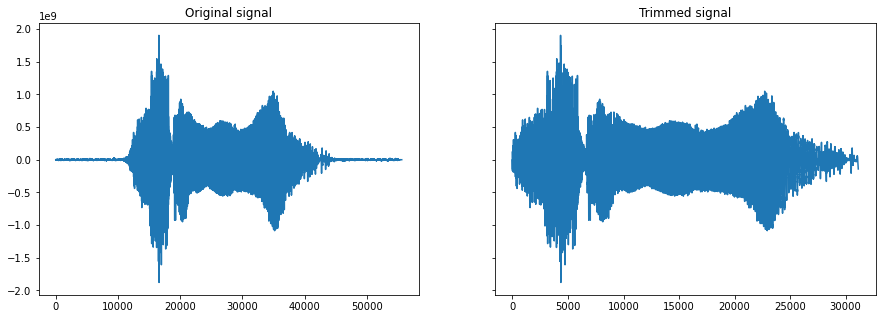

In [41]:
#Example
_, signal = wavfile.read('data/生命.wav')

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].plot(signal)
ax[0].set_title("Original signal")
ax[1].plot(trim_silence(signal))
ax[1].set_title("Trimmed signal")
plt.show()

The following function splits two sylable words into their individual sylables. In some cases, the split is proposed after the initial of the second sylable; however, because the tone is contained in the final, this is not a problem for the present task.

In [42]:
def split_on_silence(signal):
    """
    Split the signal into two parts
    the split is based on the minimum of the mean absolute 
    amplitude of 1% chunks in the middle third of the signal
    """
    chunk_length = len(signal) // 100
    silent = [np.mean(np.abs(signal[i:i+chunk_length-1])) for i in range(0, len(signal), chunk_length)]
    third = len(silent)//3
    minimum = np.argmin(silent[third:2*third])
    return signal[:(third+minimum)*chunk_length], signal[(third+minimum+1)*chunk_length:]

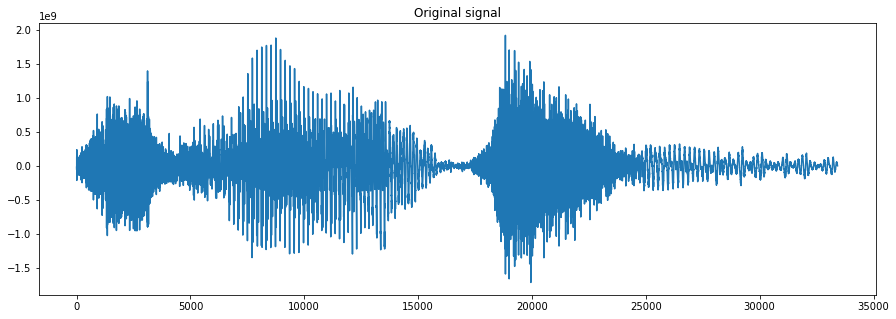

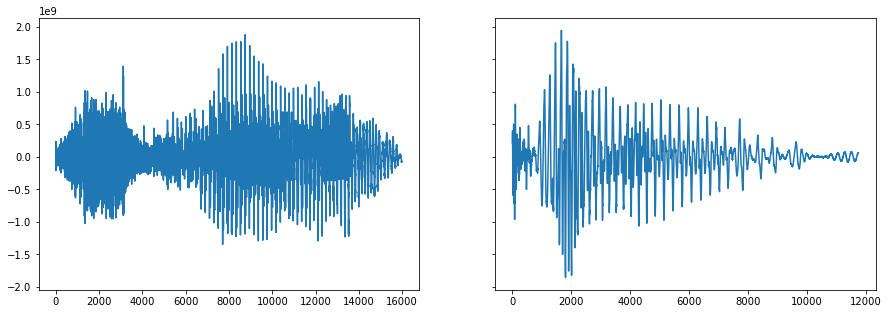

In [43]:
#Example
fs, signal = wavfile.read('data/採取.wav')
signal = trim_silence(signal)

fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(signal)
ax.set_title("Original signal")

signal1, data2 = split_on_silence(signal)
signal1 = trim_silence(signal1)
signal2 = trim_silence(signal2)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].plot(signal1)
ax[1].plot(signal2)

plt.show()

In [44]:
#Check the split is correct
wavfile.write("signal1", fs, signal1)
wavfile.write("signal2", fs, signal2)

In [45]:
AudioSegment.from_wav("signal1")

In [46]:
AudioSegment.from_wav("signal2")

In [47]:
os.remove("signal1")
os.remove("signal2")

In [48]:
def get_spectrogram(signal, fs, log=True):
    """
    Return the spectrogram for an audio input
    """
    nperseg = signal.shape[0] // 15
    f, t, Sxx = spectrogram(signal, 
                            fs, 
                            nperseg=nperseg, 
                            nfft=1024*8, 
                            noverlap=int(nperseg*0.9),
                            scaling="spectrum")
    aggregated_Sxx = np.sum(Sxx, axis=1)
    # Voiced vowels have frequency less than 2000 Hz
    f_bound = len(f)
    if False in list(f < 2000):
        f_bound = list(f < 2000).index(False)
    t_start = list(Sxx.max(axis=0) > Sxx.max() * 0.1).index(True)
    t_end = Sxx.shape[1] - list(Sxx.max(axis=0) > Sxx.max() * 0.1)[::-1].index(True)
    #t = t[t_start:t_end]
    f = f[:f_bound]
    Sxx = Sxx[:f_bound]
    if log:
        Sxx = np.log(Sxx)
    return t, f, Sxx.tolist()

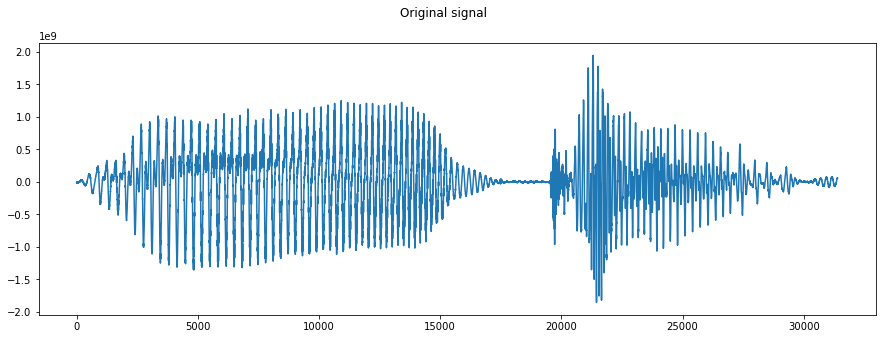

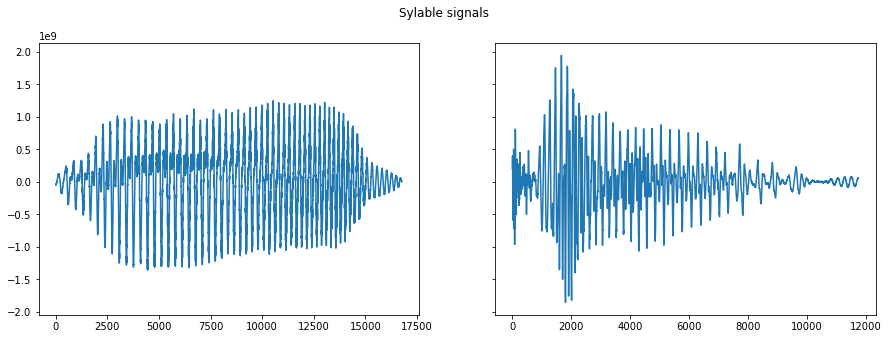

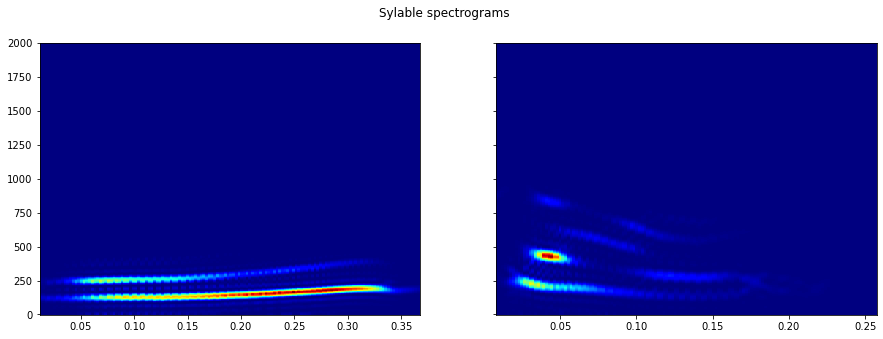

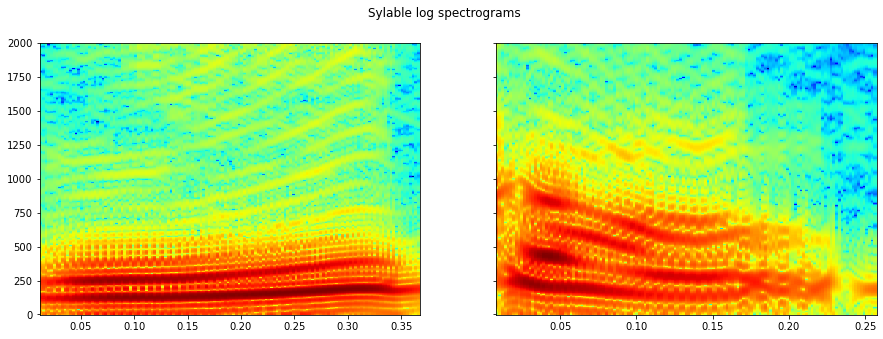

In [51]:
fs, signal = wavfile.read('data/一共.wav')

signal = trim_silence(signal)

fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(signal)
fig.suptitle("Original signal")
plt.show()

signal1, signal2 = split_on_silence(signal)
signal1 = trim_silence(signal1)
signal2 = trim_silence(signal2)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].plot(signal1)
ax[1].plot(signal2)
fig.suptitle("Sylable signals")
plt.show()

t1, f1, Sxx1 = get_spectrogram(signal1, fs, log=False)
t2, f2, Sxx2 = get_spectrogram(signal2, fs, log=False)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].pcolormesh(t1, f1, Sxx1, cmap='jet', shading='auto')
ax[1].pcolormesh(t2, f2, Sxx2, cmap='jet', shading='auto')
fig.suptitle("Sylable spectrograms")
plt.show()

t1, f1, Sxx1 = get_spectrogram(signal1, fs, log=True)
t2, f2, Sxx2 = get_spectrogram(signal2, fs, log=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].pcolormesh(t1, f1, Sxx1, cmap='jet', shading='auto')
ax[1].pcolormesh(t2, f2, Sxx2, cmap='jet', shading='auto')
fig.suptitle("Sylable log spectrograms")
plt.show()

The first and fourth tones of 一共 are clearly visible in the log spect